# ARFS - regression

ARFS can be used for classification (binary or multi-class) and for regression. You just have to specify the right loss function.



In [ ]:
# from IPython.core.display import display, HTML
# display(HTML("<style>.container { width:95% !important; }</style>"))
import numpy as np
import matplotlib.pyplot as plt
import gc
from sklearn.pipeline import Pipeline
from sklearn.base import clone
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor

import arfs
import arfs.feature_selection.allrelevant as arfsgroot
from arfs.feature_selection import (
    MissingValueThreshold,
    UniqueValuesThreshold,
    CollinearityThreshold,
    make_fs_summary,
)
from arfs.utils import LightForestRegressor
from arfs.benchmark import highlight_tick, compare_varimp
from arfs.utils import load_data

plt.style.use("fivethirtyeight")
rng = np.random.RandomState(seed=42)

# import warnings
# warnings.filterwarnings('ignore')

In [2]:
print(f"Run with ARFS {arfs.__version__}")

Run with ARFS 3.0.0


In [3]:
%matplotlib inline

In [4]:
gc.enable()
gc.collect()

4

## Simple Usage
In the following examples, I'll use a classical data set to which I added random predictors (numerical and categorical). An All Relveant FS methods should discard them.
In the unit tests, you'll find examples using artifical data with genuine (correlated and non-linear) predictors and with some random/noise columns.

## Leshy (Boruta evolution)

In [5]:
boston = load_data(name="Boston")
X, y = boston.data, boston.target

In [6]:
X.dtypes

CRIM             float64
ZN               float64
INDUS            float64
CHAS            category
NOX              float64
RM               float64
AGE              float64
DIS              float64
RAD             category
TAX              float64
PTRATIO          float64
B                float64
LSTAT            float64
random_num1      float64
random_num2        int32
random_cat      category
random_cat_2    category
genuine_num      float64
dtype: object

In [7]:
X.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,random_num1,random_num2,random_cat,random_cat_2,genuine_num
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,0.496714,0,cat_3517,Platist,7.080332
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,-0.138264,0,cat_2397,MarkZ,5.245384
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,0.647689,0,cat_3735,Dracula,6.375795
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,1.523030,0,cat_2870,Bejita,6.725118
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,-0.234153,4,cat_1160,Variance,7.867781


In [8]:
# Let's use lightgbm as booster, see below for using more models
model = LGBMRegressor(random_state=42, verbose=-1)

Native (impurity/Gini) feature importance, known to be biased.

Leshy iteration:   0%|          | 0/10 [00:00<?, ?it/s]



Leshy finished running using native var. imp.

Iteration: 	1 / 10
Confirmed: 	10
Tentative: 	2
Rejected: 	6
All relevant predictors selected in 00:00:00.87
The selected features: ['CRIM' 'NOX' 'RM' 'AGE' 'DIS' 'TAX' 'PTRATIO' 'B' 'LSTAT' 'genuine_num']
The agnostic ranking: [1 3 2 6 1 1 1 1 6 1 1 1 1 2 4 6 6 1]
The naive ranking: ['LSTAT', 'RM', 'genuine_num', 'CRIM', 'NOX', 'DIS', 'PTRATIO', 'AGE', 'TAX', 'B', 'INDUS', 'random_num1', 'ZN', 'random_num2', 'CHAS', 'RAD', 'random_cat', 'random_cat_2']


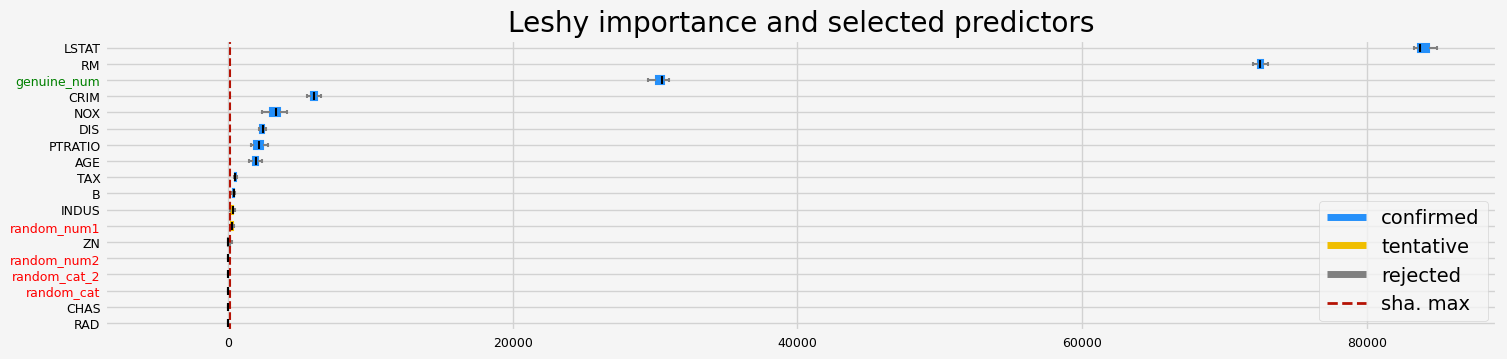

CPU times: user 1.81 s, sys: 233 ms, total: 2.04 s
Wall time: 1.61 s


In [9]:
%%time
# Leshy
feat_selector = arfsgroot.Leshy(
    model, n_estimators=20, verbose=1, max_iter=10, random_state=42, importance="native"
)
feat_selector.fit(X, y, sample_weight=None)
print(f"The selected features: {feat_selector.get_feature_names_out()}")
print(f"The agnostic ranking: {feat_selector.ranking_}")
print(f"The naive ranking: {feat_selector.ranking_absolutes_}")
fig = feat_selector.plot_importance(n_feat_per_inch=5)

# highlight synthetic random variable
fig = highlight_tick(figure=fig, str_match="random")
fig = highlight_tick(figure=fig, str_match="genuine", color="green")
plt.show()

SHAP importance

Leshy iteration:   0%|          | 0/10 [00:00<?, ?it/s]



Leshy finished running using shap var. imp.

Iteration: 	1 / 10
Confirmed: 	9
Tentative: 	2
Rejected: 	7
All relevant predictors selected in 00:00:01.49
The selected features: ['CRIM' 'NOX' 'RM' 'AGE' 'DIS' 'PTRATIO' 'LSTAT' 'random_num1'
 'genuine_num']
The agnostic ranking: [1 6 3 6 1 1 1 1 6 2 1 2 1 1 6 6 6 1]
The naive ranking: ['LSTAT', 'RM', 'genuine_num', 'CRIM', 'PTRATIO', 'DIS', 'AGE', 'random_num1', 'NOX', 'TAX', 'B', 'INDUS', 'random_num2', 'CHAS', 'RAD', 'ZN', 'random_cat', 'random_cat_2']


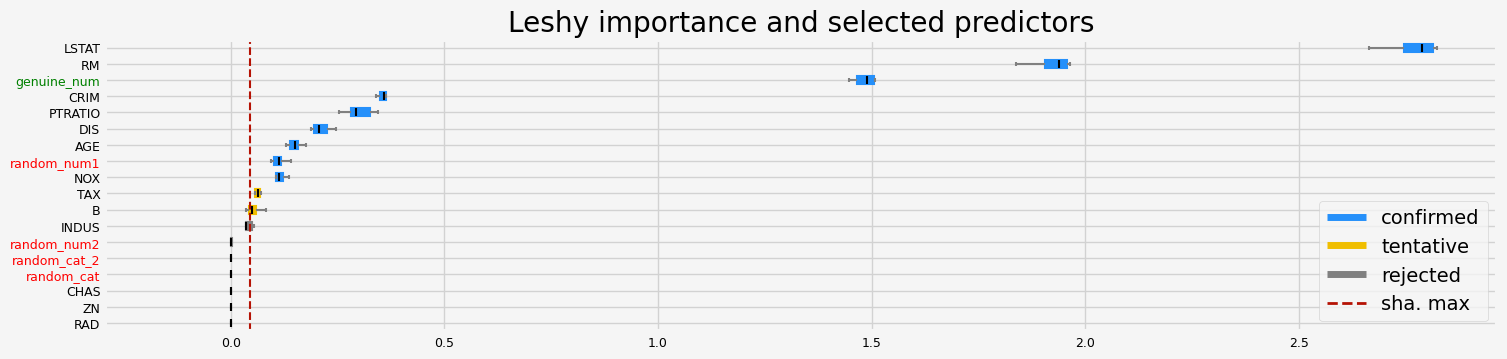

CPU times: user 2.63 s, sys: 152 ms, total: 2.78 s
Wall time: 2.29 s


In [10]:
%%time

model = clone(model)

# Leshy
feat_selector = arfsgroot.Leshy(
    model, n_estimators=20, verbose=1, max_iter=10, random_state=42, importance="shap"
)
feat_selector.fit(X, y, sample_weight=None)
print(f"The selected features: {feat_selector.get_feature_names_out()}")
print(f"The agnostic ranking: {feat_selector.ranking_}")
print(f"The naive ranking: {feat_selector.ranking_absolutes_}")
fig = feat_selector.plot_importance(n_feat_per_inch=5)

# highlight synthetic random variable
fig = highlight_tick(figure=fig, str_match="random")
fig = highlight_tick(figure=fig, str_match="genuine", color="green")
plt.show()

SHAP importance - fasttreeshap implementation

/home/bsatom/Documents/arfs/src/arfs/feature_selection/allrelevant.py:325: UserWarning: fasttreeshap is not installed. Fallback to shap.
  warnings.warn("fasttreeshap is not installed. Fallback to shap.")


Leshy iteration:   0%|          | 0/10 [00:00<?, ?it/s]



Leshy finished running using shap var. imp.

Iteration: 	1 / 10
Confirmed: 	9
Tentative: 	2
Rejected: 	7
All relevant predictors selected in 00:00:01.97
The selected features: ['CRIM' 'NOX' 'RM' 'AGE' 'DIS' 'PTRATIO' 'LSTAT' 'random_num1'
 'genuine_num']
The agnostic ranking: [1 6 3 6 1 1 1 1 6 2 1 2 1 1 6 6 6 1]
The naive ranking: ['LSTAT', 'RM', 'genuine_num', 'CRIM', 'PTRATIO', 'DIS', 'AGE', 'random_num1', 'NOX', 'TAX', 'B', 'INDUS', 'random_num2', 'CHAS', 'RAD', 'ZN', 'random_cat', 'random_cat_2']


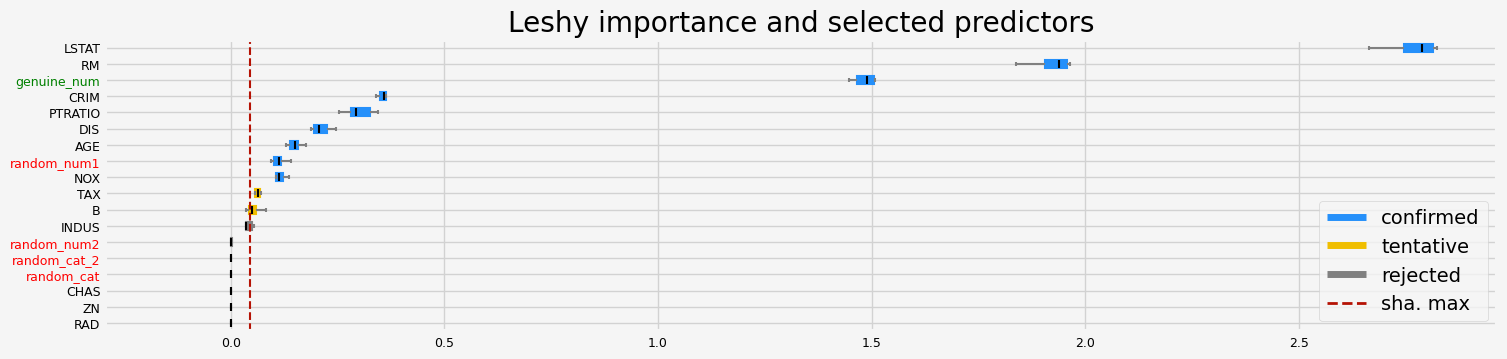

CPU times: user 2.93 s, sys: 204 ms, total: 3.13 s
Wall time: 2.98 s


In [11]:
%%time

model = clone(model)

# Leshy
feat_selector = arfsgroot.Leshy(
    model,
    n_estimators=20,
    verbose=1,
    max_iter=10,
    random_state=42,
    importance="fastshap",
)
feat_selector.fit(X, y, sample_weight=None)
print(f"The selected features: {feat_selector.get_feature_names_out()}")
print(f"The agnostic ranking: {feat_selector.ranking_}")
print(f"The naive ranking: {feat_selector.ranking_absolutes_}")
fig = feat_selector.plot_importance(n_feat_per_inch=5)

# highlight synthetic random variable
fig = highlight_tick(figure=fig, str_match="random")
fig = highlight_tick(figure=fig, str_match="genuine", color="green")
plt.show()

with permutation importance

Leshy iteration:   0%|          | 0/10 [00:00<?, ?it/s]



Leshy finished running using pimp var. imp.

Iteration: 	1 / 10
Confirmed: 	7
Tentative: 	5
Rejected: 	6
All relevant predictors selected in 00:00:14.25
The selected features: ['CRIM' 'NOX' 'RM' 'DIS' 'PTRATIO' 'LSTAT' 'genuine_num']
The agnostic ranking: [1 3 2 3 1 1 2 1 3 2 1 2 1 2 3 3 3 1]
The naive ranking: ['LSTAT', 'RM', 'genuine_num', 'CRIM', 'PTRATIO', 'DIS', 'NOX', 'TAX', 'B', 'AGE', 'INDUS', 'random_num1', 'random_num2', 'CHAS', 'RAD', 'ZN', 'random_cat', 'random_cat_2']


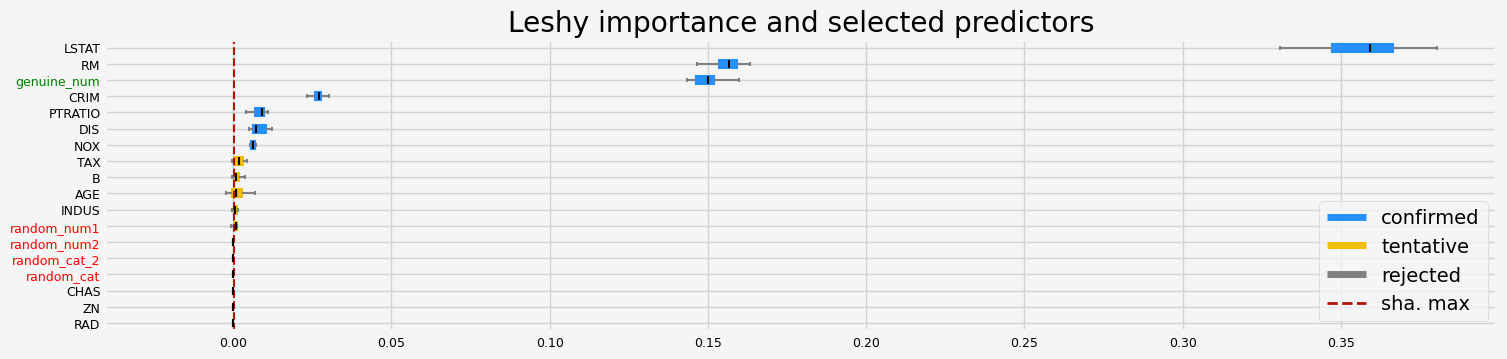

CPU times: user 5.16 s, sys: 393 ms, total: 5.55 s
Wall time: 14.9 s


In [12]:
%%time

model = clone(model)

# Leshy
feat_selector = arfsgroot.Leshy(
    model, n_estimators=20, verbose=1, max_iter=10, random_state=42, importance="pimp"
)
feat_selector.fit(X, y, sample_weight=None)
print(f"The selected features: {feat_selector.get_feature_names_out()}")
print(f"The agnostic ranking: {feat_selector.ranking_}")
print(f"The naive ranking: {feat_selector.ranking_absolutes_}")
fig = feat_selector.plot_importance(n_feat_per_inch=5)

# highlight synthetic random variable
fig = highlight_tick(figure=fig, str_match="random")
fig = highlight_tick(figure=fig, str_match="genuine", color="green")
plt.show()

## BoostAGroota

with SHAP importance

BoostaGRoota round:   0%|          | 0/10 [00:00<?, ?it/s]

The selected features: ['CRIM' 'NOX' 'RM' 'AGE' 'DIS' 'PTRATIO' 'LSTAT' 'random_num1'
 'genuine_num']
The agnostic ranking: [2 1 1 1 2 2 2 2 1 1 2 1 2 2 1 1 1 2]
The naive ranking: ['LSTAT', 'RM', 'genuine_num', 'CRIM', 'PTRATIO', 'DIS', 'AGE', 'random_num1', 'NOX', 'TAX', 'B', 'INDUS', 'random_num2', 'ZN', 'CHAS', 'RAD', 'random_cat', 'random_cat_2']


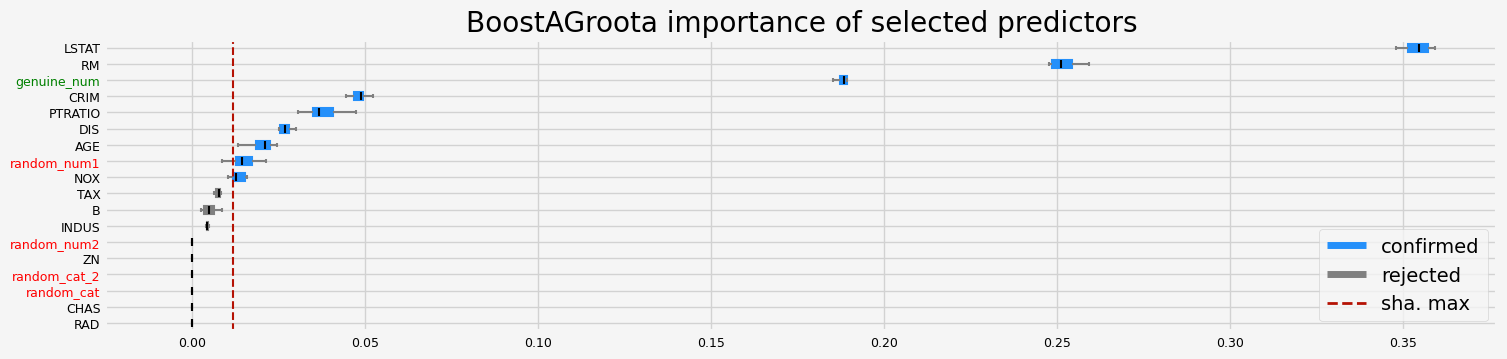

CPU times: user 2.11 s, sys: 209 ms, total: 2.32 s
Wall time: 1.49 s


In [13]:
%%time

# be sure to use the same but non-fitted estimator
model = clone(model)
# BoostAGroota
feat_selector = arfsgroot.BoostAGroota(
    estimator=model, cutoff=1, iters=10, max_rounds=10, delta=0.1, importance="shap"
)
feat_selector.fit(X, y, sample_weight=None)
print(f"The selected features: {feat_selector.get_feature_names_out()}")
print(f"The agnostic ranking: {feat_selector.ranking_}")
print(f"The naive ranking: {feat_selector.ranking_absolutes_}")
fig = feat_selector.plot_importance(n_feat_per_inch=5)

# highlight synthetic random variable
fig = highlight_tick(figure=fig, str_match="random")
fig = highlight_tick(figure=fig, str_match="genuine", color="green")
plt.show()

with SHAP importance - fasttreeshap implementation

/home/bsatom/Documents/arfs/src/arfs/feature_selection/allrelevant.py:1556: UserWarning: fasttreeshap is not installed. Fallback to shap.
  warnings.warn("fasttreeshap is not installed. Fallback to shap.")


BoostaGRoota round:   0%|          | 0/10 [00:00<?, ?it/s]

The selected features: ['CRIM' 'NOX' 'RM' 'AGE' 'DIS' 'PTRATIO' 'LSTAT' 'random_num1'
 'genuine_num']
The agnostic ranking: [2 1 1 1 2 2 2 2 1 1 2 1 2 2 1 1 1 2]
The naive ranking: ['LSTAT', 'RM', 'genuine_num', 'CRIM', 'PTRATIO', 'DIS', 'AGE', 'NOX', 'random_num1', 'TAX', 'B', 'INDUS', 'random_cat', 'random_cat_2', 'RAD', 'random_num2', 'CHAS', 'ZN']


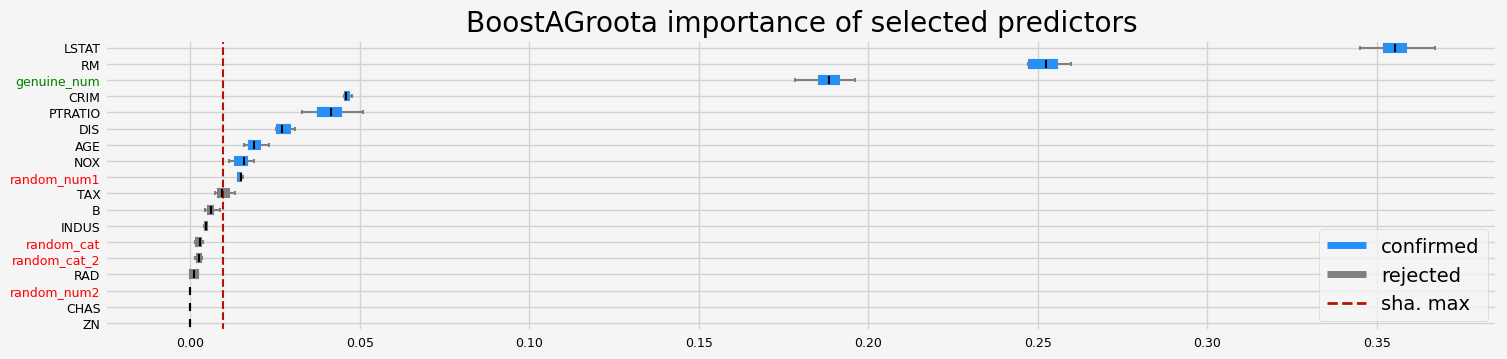

CPU times: user 2.99 s, sys: 218 ms, total: 3.21 s
Wall time: 2.03 s


In [14]:
%%time

# be sure to use the same but non-fitted estimator
model = clone(model)
# BoostAGroota
feat_selector = arfsgroot.BoostAGroota(
    estimator=model, cutoff=1, iters=10, max_rounds=10, delta=0.1, importance="fastshap"
)
feat_selector.fit(X, y, sample_weight=None)
print(f"The selected features: {feat_selector.get_feature_names_out()}")
print(f"The agnostic ranking: {feat_selector.ranking_}")
print(f"The naive ranking: {feat_selector.ranking_absolutes_}")
fig = feat_selector.plot_importance(n_feat_per_inch=5)

# highlight synthetic random variable
fig = highlight_tick(figure=fig, str_match="random")
fig = highlight_tick(figure=fig, str_match="genuine", color="green")
plt.show()

In [15]:
feat_selector.get_params()

{'cutoff': 1,
 'delta': 0.1,
 'estimator__boosting_type': 'gbdt',
 'estimator__class_weight': None,
 'estimator__colsample_bytree': 1.0,
 'estimator__importance_type': 'split',
 'estimator__learning_rate': 0.1,
 'estimator__max_depth': -1,
 'estimator__min_child_samples': 20,
 'estimator__min_child_weight': 0.001,
 'estimator__min_split_gain': 0.0,
 'estimator__n_estimators': 20,
 'estimator__n_jobs': None,
 'estimator__num_leaves': 31,
 'estimator__objective': None,
 'estimator__random_state': 8414,
 'estimator__reg_alpha': 0.0,
 'estimator__reg_lambda': 0.0,
 'estimator__subsample': 1.0,
 'estimator__subsample_for_bin': 200000,
 'estimator__subsample_freq': 0,
 'estimator__verbose': -1,
 'estimator': LGBMRegressor(n_estimators=20, random_state=8414, verbose=-1),
 'importance': 'shap',
 'iters': 10,
 'max_rounds': 10,
 'silent': True}

## GrootCV

Cross Validation:   0%|          | 0/25 [00:00<?, ?it/s]

Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[218]	training's l2: 0.234061	valid_1's l2: 14.8556
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[193]	training's l2: 0.184973	valid_1's l2: 9.97102
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[87]	training's l2: 1.15408	valid_1's l2: 8.78114
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[163]	training's l2: 0.275966	valid_1's l2: 7.70544
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[103]	training's l2: 1.17445	valid_1's l2: 13.0363
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[60]	training's l2: 1.84813	valid_1's l2: 11.5547
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[168]	training's l2: 

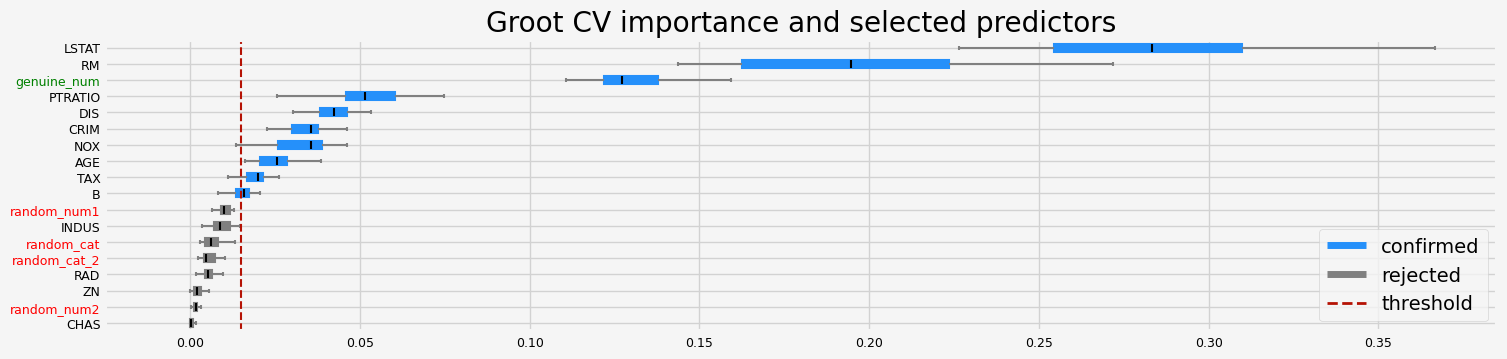

CPU times: user 25.3 s, sys: 2.01 s, total: 27.3 s
Wall time: 12.9 s


In [16]:
%%time
# GrootCV
feat_selector = arfsgroot.GrootCV(
    objective="rmse",
    cutoff=1,
    n_folds=5,
    n_iter=5,
    silent=True,
    fastshap=False,
    n_jobs=0,
)
feat_selector.fit(X, y, sample_weight=None)
print(f"The selected features: {feat_selector.get_feature_names_out()}")
print(f"The agnostic ranking: {feat_selector.ranking_}")
print(f"The naive ranking: {feat_selector.ranking_absolutes_}")
fig = feat_selector.plot_importance(n_feat_per_inch=5)

# highlight synthetic random variable
fig = highlight_tick(figure=fig, str_match="random")
fig = highlight_tick(figure=fig, str_match="genuine", color="green")
plt.show()

enabling fasttreeshap

In [17]:
%%time
# GrootCV
feat_selector = arfsgroot.GrootCV(
    objective="rmse",
    cutoff=1,
    n_folds=5,
    n_iter=5,
    silent=True,
    fastshap=True,
    n_jobs=0,
)
feat_selector.fit(X, y, sample_weight=None)
print(f"The selected features: {feat_selector.get_feature_names_out()}")
print(f"The agnostic ranking: {feat_selector.ranking_}")
print(f"The naive ranking: {feat_selector.ranking_absolutes_}")
fig = feat_selector.plot_importance(n_feat_per_inch=5)

# highlight synthetic random variable
fig = highlight_tick(figure=fig, str_match="random")
fig = highlight_tick(figure=fig, str_match="genuine", color="green")
plt.show()

Cross Validation:   0%|          | 0/25 [00:00<?, ?it/s]

Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[342]	training's l2: 0.0867896	valid_1's l2: 13.0855


RuntimeError: SHAP computation failed: No module named 'fasttreeshap'

## ARFS in sklearn pipelines

all the selectors (basic, arfs and MRmr) are sklearn compatible and follows the same architecture. Namely, they use the sklearn relevant base classes and therefore have the same methods.

In [18]:
feat_selector = arfsgroot.GrootCV(
    objective="rmse", cutoff=1, n_folds=5, n_iter=5, silent=True
)

arfs_fs_pipeline = Pipeline(
    [
        ("missing", MissingValueThreshold(threshold=0.05)),
        ("unique", UniqueValuesThreshold(threshold=1)),
        ("collinearity", CollinearityThreshold(threshold=0.85)),
        ("arfs", feat_selector),
    ]
)

X_trans = arfs_fs_pipeline.fit(X=X, y=y).transform(X=X)

Cross Validation:   0%|          | 0/25 [00:00<?, ?it/s]

Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1063]	training's l2: 0.000629921	valid_1's l2: 12.2328
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[92]	training's l2: 0.970287	valid_1's l2: 13.5527
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[62]	training's l2: 2.06957	valid_1's l2: 8.97033
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[33]	training's l2: 4.08651	valid_1's l2: 9.11467
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[118]	training's l2: 1.21085	valid_1's l2: 12.6812
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[98]	training's l2: 0.877936	valid_1's l2: 12.0485
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[101]	training's l2

you can access the attributes of a step as you would in any sklearn pipeline

In [19]:
arfs_fs_pipeline.named_steps["collinearity"].get_feature_names_out()

array(['CRIM', 'ZN', 'INDUS', 'CHAS', 'RM', 'AGE', 'DIS', 'RAD', 'TAX',
       'PTRATIO', 'B', 'LSTAT', 'random_num1', 'random_num2',
       'random_cat', 'random_cat_2', 'genuine_num'], dtype=object)

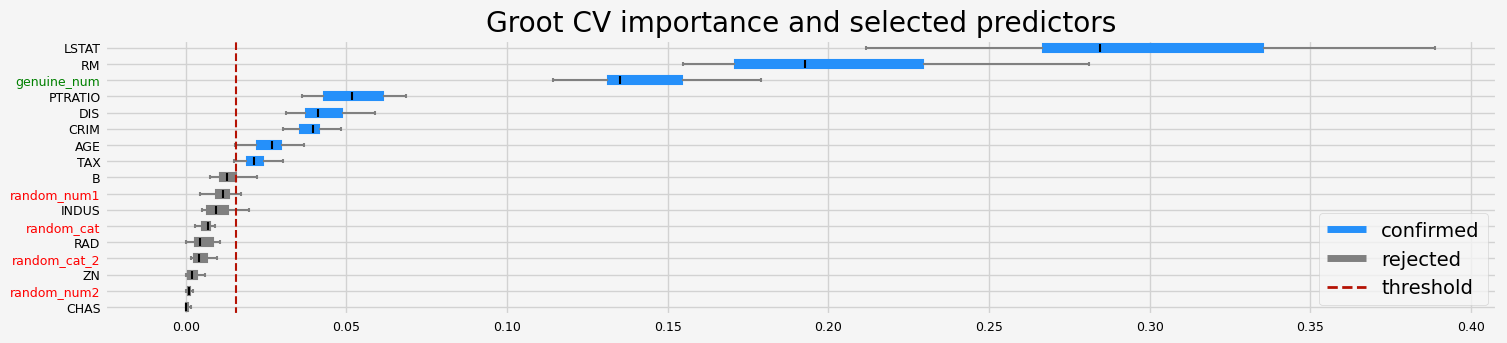

In [20]:
fig = arfs_fs_pipeline.named_steps["arfs"].plot_importance()
# highlight synthetic random variable
fig = highlight_tick(figure=fig, str_match="random")
fig = highlight_tick(figure=fig, str_match="genuine", color="green")
plt.show()

In [21]:
make_fs_summary(arfs_fs_pipeline)

/home/bsatom/Documents/arfs/src/arfs/feature_selection/summary.py:69: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  .applymap(lambda x: "" if x == x else "background-color: #f57505")


,predictor,missing,unique,collinearity,arfs
0,CRIM,1,1,1,1
1,ZN,1,1,1,0
2,INDUS,1,1,1,0
3,CHAS,1,1,1,0
4,NOX,1,1,0,nan
5,RM,1,1,1,1
6,AGE,1,1,1,1
7,DIS,1,1,1,1
8,RAD,1,1,1,0
9,TAX,1,1,1,1


## Testing and comparing Leshy, GrootCV and BoostAGroota 

In the following examples, I'll use different models which are scikit-learn compatible and then one can compare the different ARFS methods with different models and the different feature importance.

==================== Benchmarking using sklearn permutation importance ====================


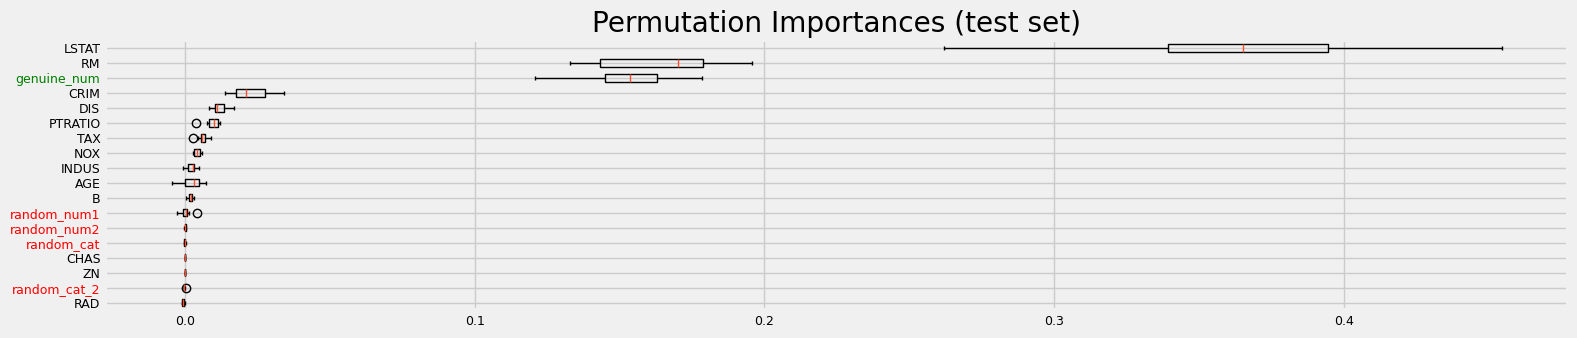

CPU times: user 1.07 s, sys: 287 ms, total: 1.36 s
Wall time: 4.12 s


In [22]:
%%time
model = clone(model)
# Benchmark with scikit-learn permutation importance
print("=" * 20 + " Benchmarking using sklearn permutation importance " + "=" * 20)
fig = sklearn_pimp_bench(model, X, y, task="regression", sample_weight=None)

### Testing Leshy

Leshy seems to struggle with catboost, for regression and this particular data set whereas the other ARFS methods seem OK. To be investigated.

==================== Leshy - testing:     RandomForestRegressor for var.imp: shap            ====================


Leshy iteration:   0%|          | 0/10 [00:00<?, ?it/s]



Leshy finished running using shap var. imp.

Iteration: 	1 / 10
Confirmed: 	11
Tentative: 	1
Rejected: 	6
All relevant predictors selected in 00:00:21.25
['CRIM' 'NOX' 'RM' 'AGE' 'DIS' 'TAX' 'PTRATIO' 'B' 'LSTAT' 'random_num1'
 'genuine_num']


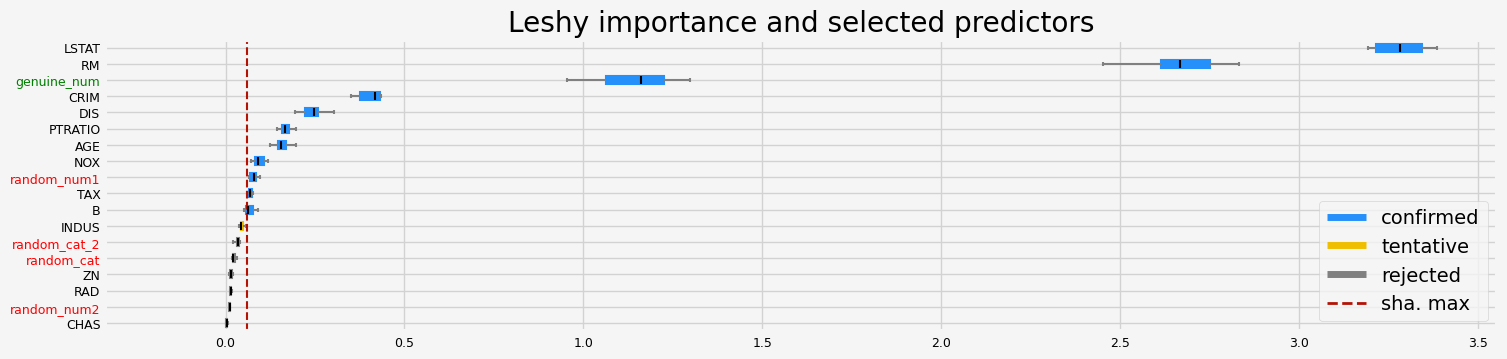

==================== Leshy - testing:     RandomForestRegressor for var.imp: pimp            ====================


Leshy iteration:   0%|          | 0/10 [00:00<?, ?it/s]



Leshy finished running using pimp var. imp.

Iteration: 	1 / 10
Confirmed: 	9
Tentative: 	2
Rejected: 	7
All relevant predictors selected in 00:00:56.26
['CRIM' 'NOX' 'RM' 'AGE' 'DIS' 'TAX' 'PTRATIO' 'LSTAT' 'genuine_num']


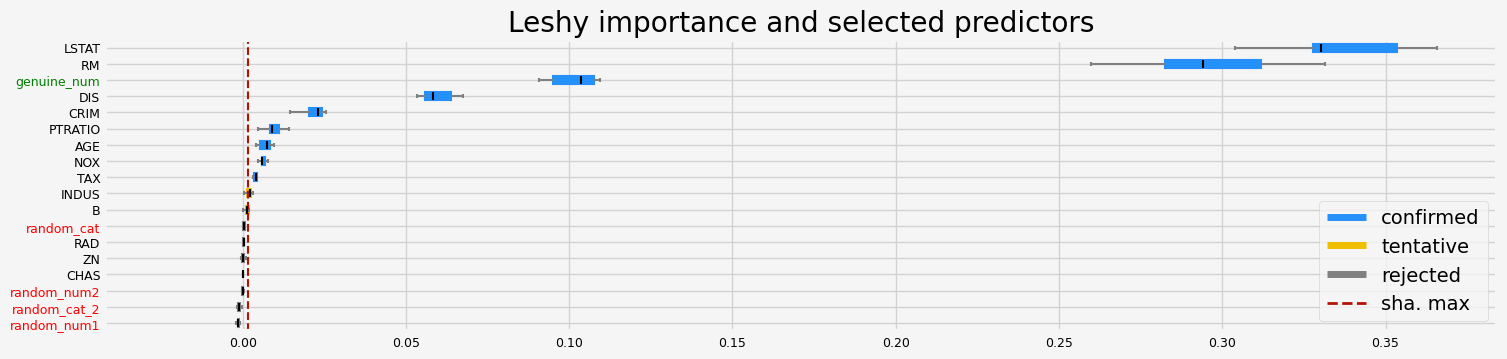

==================== Leshy - testing:     RandomForestRegressor for var.imp: native          ====================


Leshy iteration:   0%|          | 0/10 [00:00<?, ?it/s]



Leshy finished running using native var. imp.

Iteration: 	1 / 10
Confirmed: 	11
Tentative: 	0
Rejected: 	7
All relevant predictors selected in 00:00:07.73
['CRIM' 'INDUS' 'NOX' 'RM' 'AGE' 'DIS' 'TAX' 'PTRATIO' 'B' 'LSTAT'
 'genuine_num']


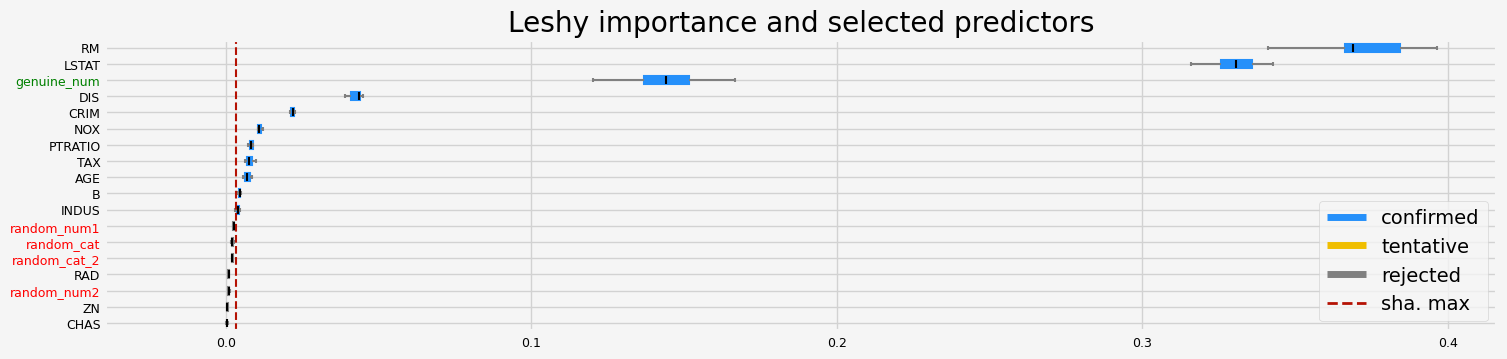

==================== Leshy - testing:         CatBoostRegressor for var.imp: shap            ====================


Leshy iteration:   0%|          | 0/10 [00:00<?, ?it/s]



Leshy finished running using shap var. imp.

Iteration: 	1 / 10
Confirmed: 	7
Tentative: 	5
Rejected: 	6
All relevant predictors selected in 00:00:07.48
['CRIM' 'RM' 'DIS' 'PTRATIO' 'B' 'LSTAT' 'genuine_num']


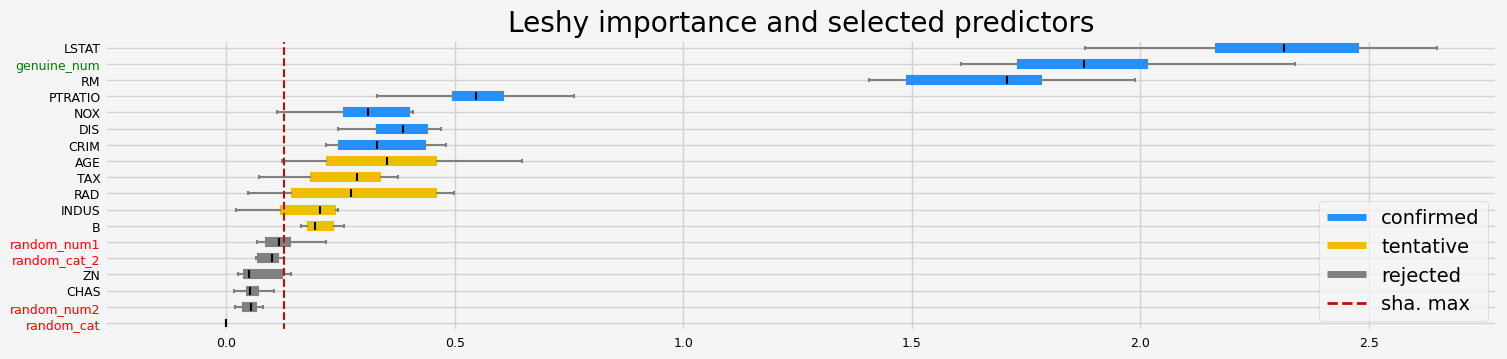

==================== Leshy - testing:         CatBoostRegressor for var.imp: pimp            ====================


Leshy iteration:   0%|          | 0/10 [00:00<?, ?it/s]



Leshy finished running using pimp var. imp.

Iteration: 	1 / 10
Confirmed: 	9
Tentative: 	3
Rejected: 	6
All relevant predictors selected in 00:00:15.12
['NOX' 'RM' 'AGE' 'DIS' 'RAD' 'TAX' 'PTRATIO' 'LSTAT' 'genuine_num']


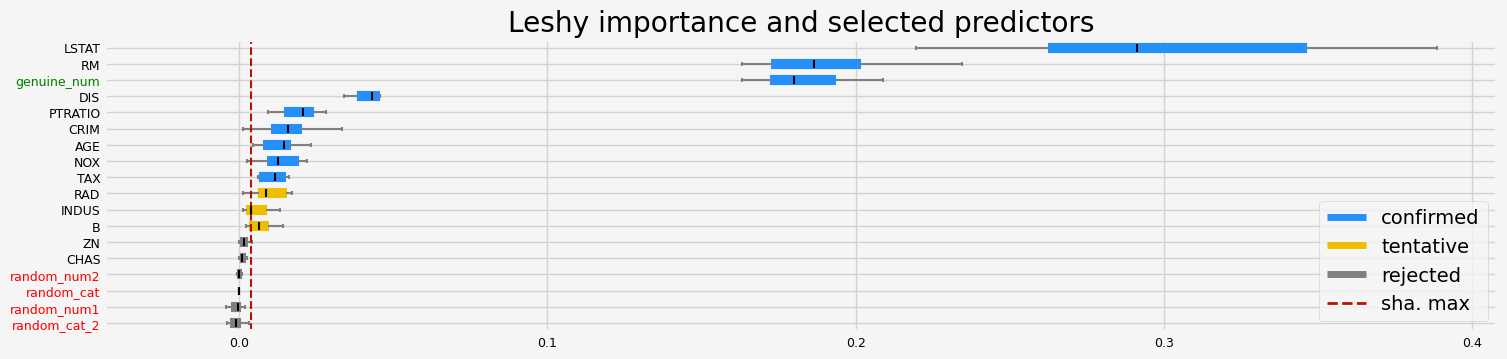

==================== Leshy - testing:         CatBoostRegressor for var.imp: native          ====================


Leshy iteration:   0%|          | 0/10 [00:00<?, ?it/s]



Leshy finished running using native var. imp.

Iteration: 	1 / 10
Confirmed: 	7
Tentative: 	4
Rejected: 	7
All relevant predictors selected in 00:00:07.10
['NOX' 'RM' 'DIS' 'TAX' 'PTRATIO' 'LSTAT' 'genuine_num']


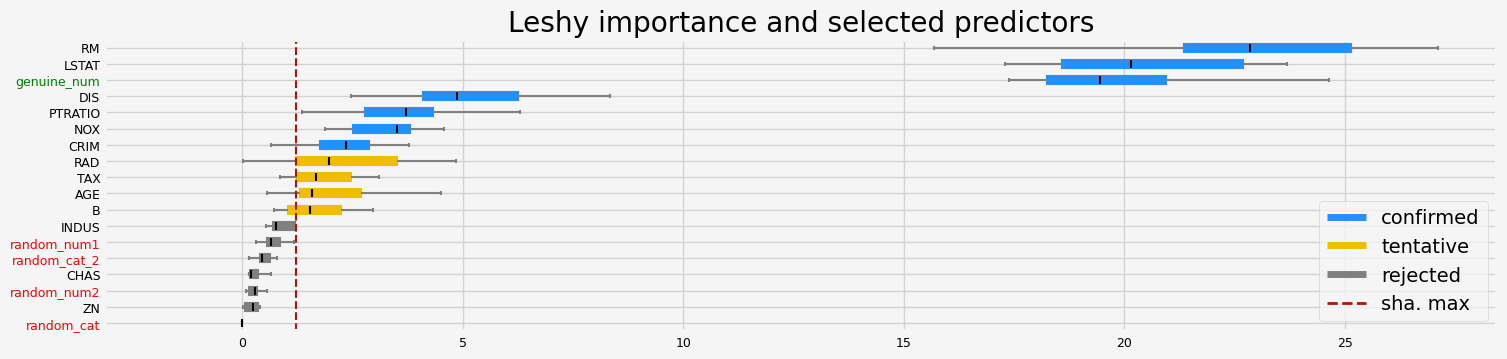

==================== Leshy - testing:             LGBMRegressor for var.imp: shap            ====================


Leshy iteration:   0%|          | 0/10 [00:00<?, ?it/s]



Leshy finished running using shap var. imp.

Iteration: 	1 / 10
Confirmed: 	8
Tentative: 	2
Rejected: 	8
All relevant predictors selected in 00:00:02.31
['CRIM' 'NOX' 'RM' 'AGE' 'DIS' 'PTRATIO' 'LSTAT' 'genuine_num']


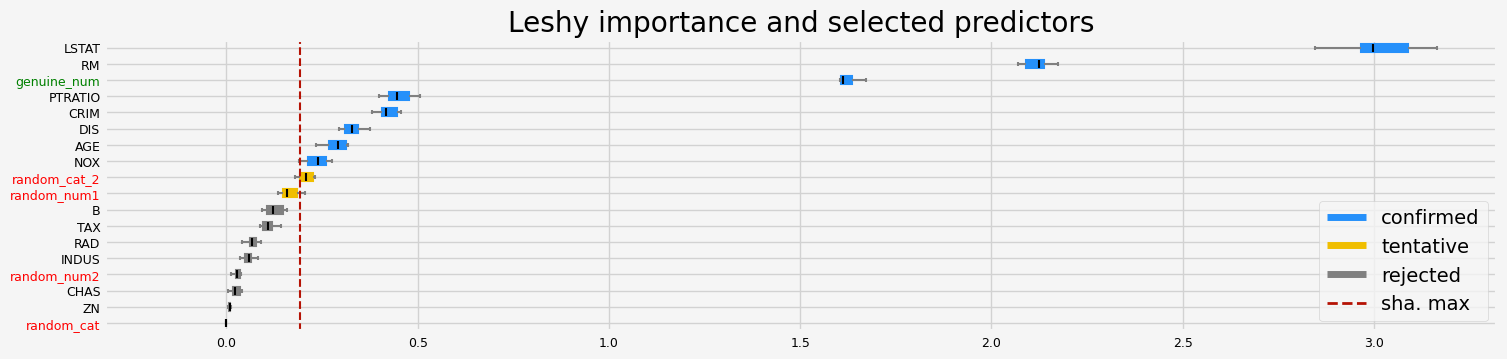

==================== Leshy - testing:             LGBMRegressor for var.imp: pimp            ====================


Leshy iteration:   0%|          | 0/10 [00:00<?, ?it/s]



Leshy finished running using pimp var. imp.

Iteration: 	1 / 10
Confirmed: 	8
Tentative: 	3
Rejected: 	7
All relevant predictors selected in 00:00:11.82
['CRIM' 'NOX' 'RM' 'AGE' 'DIS' 'PTRATIO' 'LSTAT' 'genuine_num']


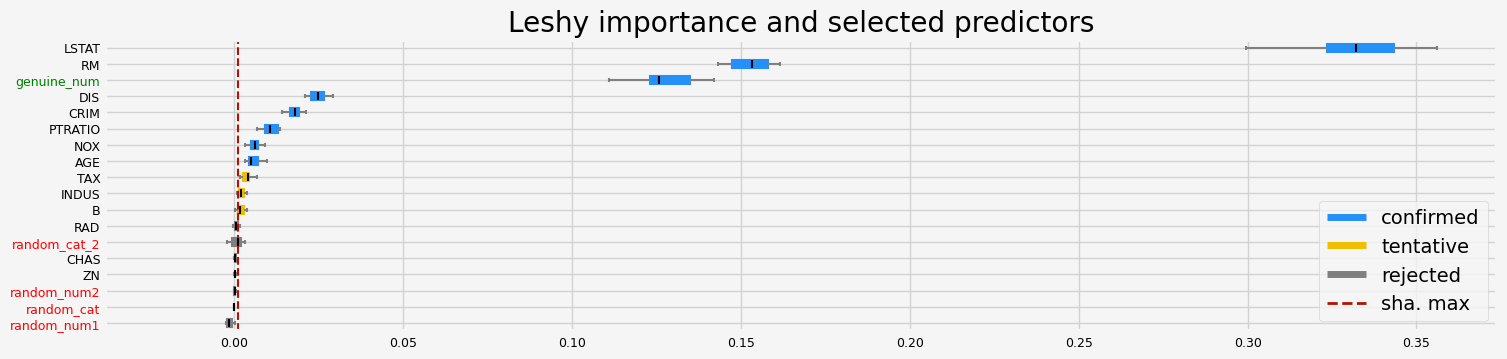

==================== Leshy - testing:             LGBMRegressor for var.imp: native          ====================


Leshy iteration:   0%|          | 0/10 [00:00<?, ?it/s]



Leshy finished running using native var. imp.

Iteration: 	1 / 10
Confirmed: 	11
Tentative: 	2
Rejected: 	5
All relevant predictors selected in 00:00:01.73
['CRIM' 'NOX' 'RM' 'AGE' 'DIS' 'TAX' 'PTRATIO' 'B' 'LSTAT' 'random_cat_2'
 'genuine_num']


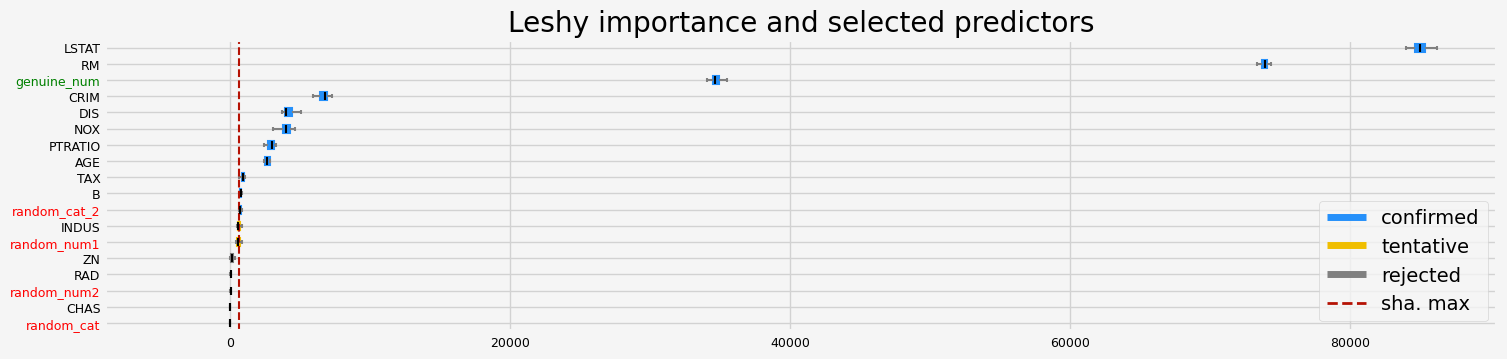

==================== Leshy - testing:             LGBMRegressor for var.imp: shap            ====================


Leshy iteration:   0%|          | 0/10 [00:00<?, ?it/s]



Leshy finished running using shap var. imp.

Iteration: 	1 / 10
Confirmed: 	11
Tentative: 	2
Rejected: 	5
All relevant predictors selected in 00:00:01.43
['CRIM' 'INDUS' 'NOX' 'RM' 'AGE' 'DIS' 'TAX' 'PTRATIO' 'B' 'LSTAT'
 'genuine_num']


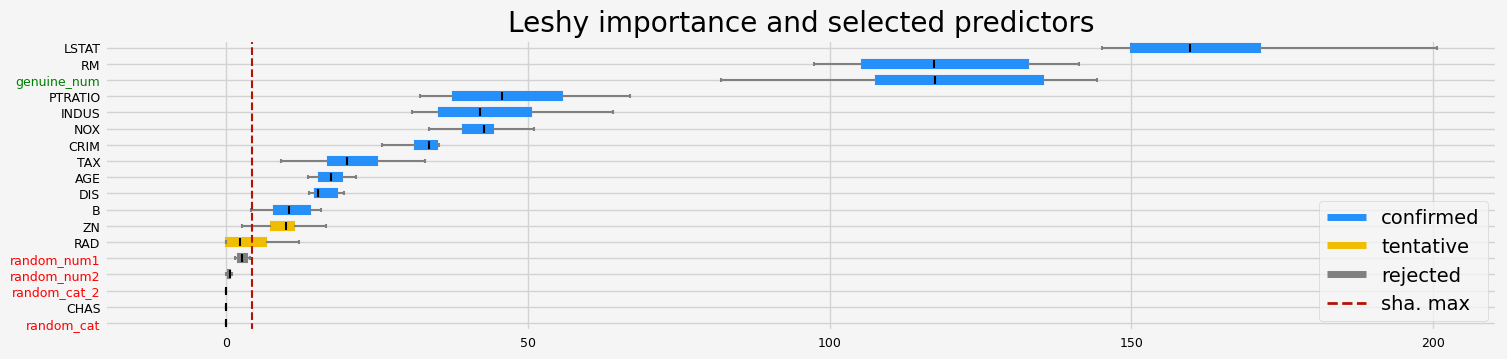

==================== Leshy - testing:             LGBMRegressor for var.imp: pimp            ====================


Leshy iteration:   0%|          | 0/10 [00:00<?, ?it/s]



Leshy finished running using pimp var. imp.

Iteration: 	1 / 10
Confirmed: 	9
Tentative: 	2
Rejected: 	7
All relevant predictors selected in 00:00:10.03
['CRIM' 'INDUS' 'NOX' 'RM' 'DIS' 'TAX' 'PTRATIO' 'LSTAT' 'genuine_num']


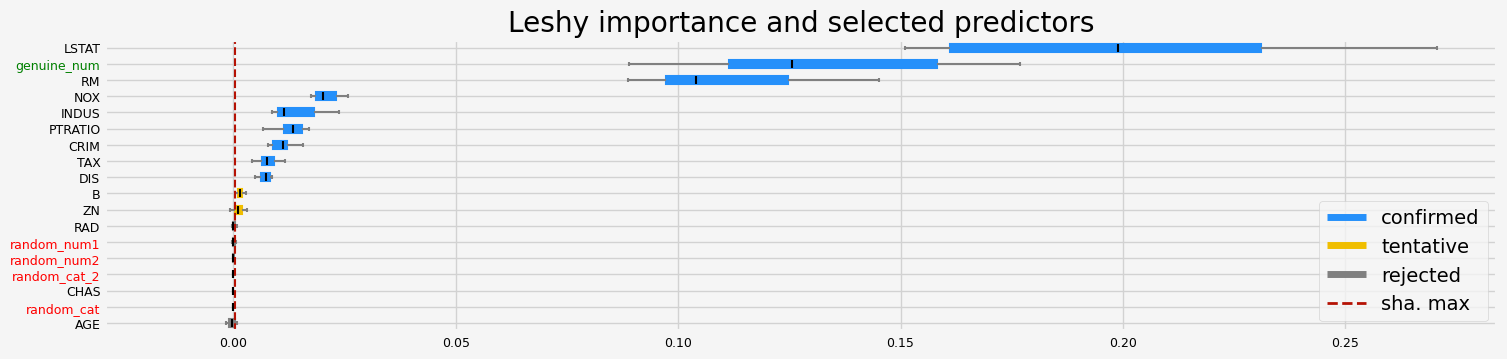

==================== Leshy - testing:             LGBMRegressor for var.imp: native          ====================


Leshy iteration:   0%|          | 0/10 [00:00<?, ?it/s]



Leshy finished running using native var. imp.

Iteration: 	1 / 10
Confirmed: 	12
Tentative: 	1
Rejected: 	5
All relevant predictors selected in 00:00:01.11
['CRIM' 'ZN' 'INDUS' 'NOX' 'RM' 'AGE' 'DIS' 'TAX' 'PTRATIO' 'B' 'LSTAT'
 'genuine_num']


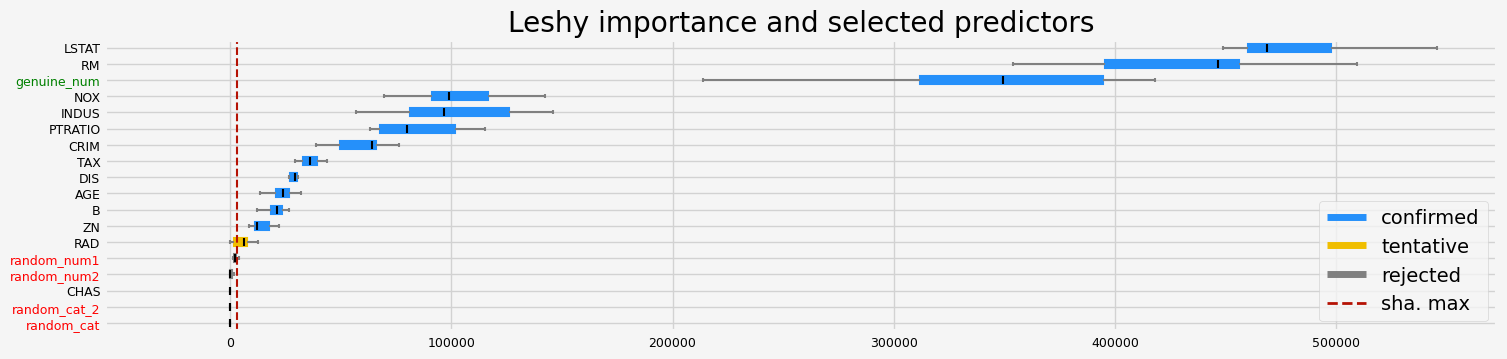

==================== Leshy - testing:              XGBRegressor for var.imp: shap            ====================


Leshy iteration:   0%|          | 0/10 [00:00<?, ?it/s]



Leshy finished running using shap var. imp.

Iteration: 	1 / 10
Confirmed: 	8
Tentative: 	3
Rejected: 	7
All relevant predictors selected in 00:00:14.64
['CRIM' 'RM' 'AGE' 'DIS' 'PTRATIO' 'B' 'LSTAT' 'genuine_num']


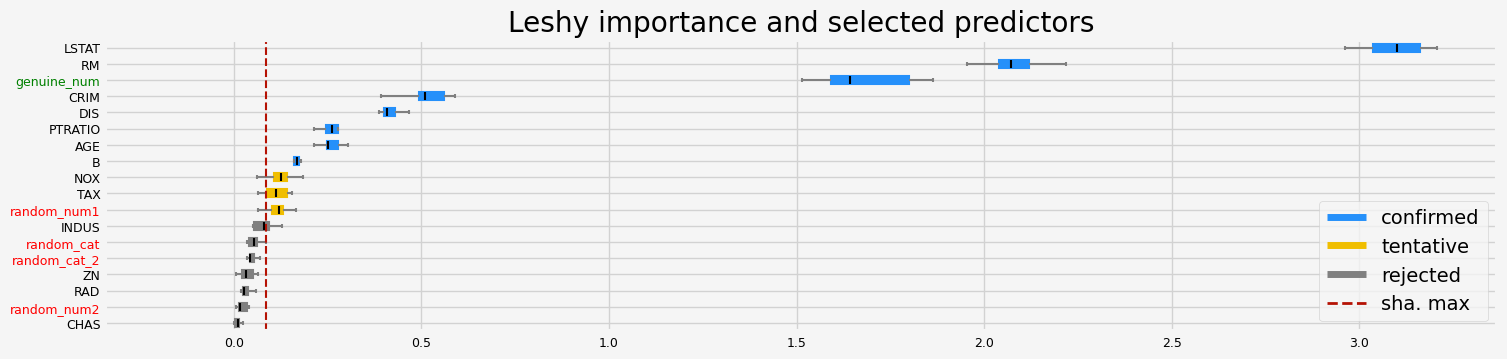

==================== Leshy - testing:              XGBRegressor for var.imp: pimp            ====================


Leshy iteration:   0%|          | 0/10 [00:00<?, ?it/s]



Leshy finished running using pimp var. imp.

Iteration: 	1 / 10
Confirmed: 	6
Tentative: 	5
Rejected: 	7
All relevant predictors selected in 00:00:13.71
['RM' 'AGE' 'DIS' 'PTRATIO' 'LSTAT' 'genuine_num']


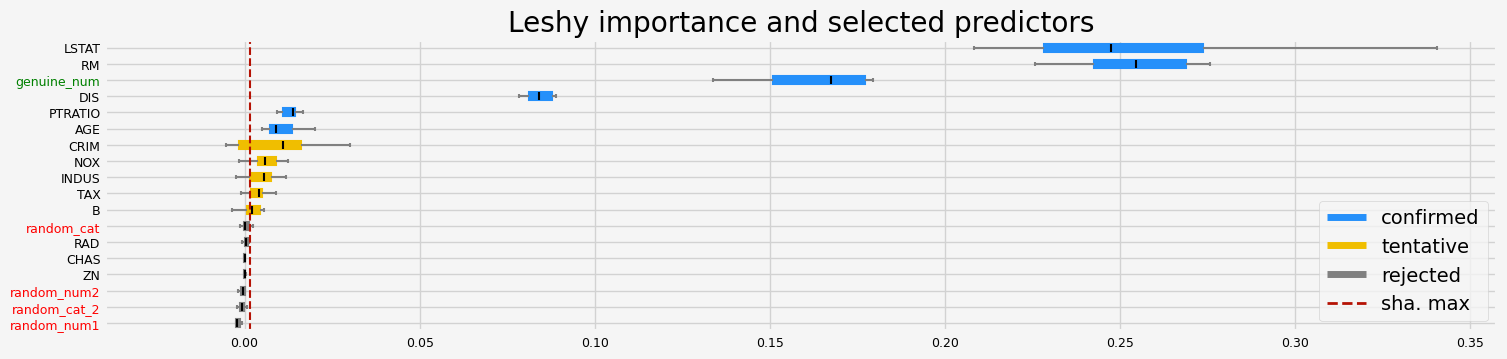

==================== Leshy - testing:              XGBRegressor for var.imp: native          ====================


Leshy iteration:   0%|          | 0/10 [00:00<?, ?it/s]



Leshy finished running using native var. imp.

Iteration: 	1 / 10
Confirmed: 	8
Tentative: 	2
Rejected: 	8
All relevant predictors selected in 00:00:07.30
['CRIM' 'NOX' 'RM' 'DIS' 'TAX' 'PTRATIO' 'LSTAT' 'genuine_num']


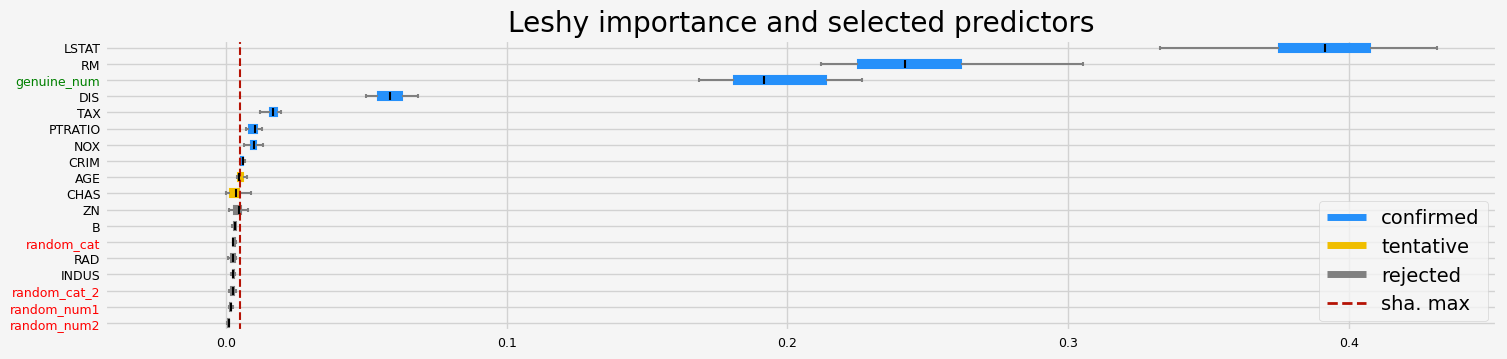

In [23]:
models = [
    RandomForestRegressor(n_jobs=4, oob_score=True),
    CatBoostRegressor(random_state=42, verbose=0),
    LGBMRegressor(random_state=42, verbose=-1),
    LightForestRegressor(n_feat=X.shape[1]),
    XGBRegressor(random_state=42, verbosity=0),
]

feat_selector = arfsgroot.Leshy(
    model, n_estimators=100, verbose=1, max_iter=10, random_state=42
)

if __name__ == "__main__":
    # regression
    boston = load_data(name="Boston")
    X, y = boston.data, boston.target
    # running the ARFS methods using different models
    compare_varimp(feat_selector, models, X, y, sample_weight=None)

In [24]:
# from sklearn.datasets import make_regression
# from xgboost import XGBRegressor
# from lightgbm import LGBMRegressor
# from fasttreeshap import TreeExplainer as FastTreeExplainer

# X, y = make_regression(
#     n_samples=1000, n_features=10, n_informative=8, noise=1, random_state=8
# )
# model = XGBRegressor()  # LGBMRegressor()
# model.fit(X, y)
# explainer = FastTreeExplainer(
#     model, algorithm="auto", shortcut=False, feature_perturbation="tree_path_dependent"
# )
# shap_matrix = explainer.shap_values(X)

FastTreeShap fails when using XGBoost, I opened an issue. 

In [25]:
# import fasttreeshap
# import shap
# import xgboost

# print(
#     f"Using xgboost {xgboost.__version__}, shap {shap.__version__} and fasttreeshap {fasttreeshap.__version__}"
# )

### Testing GrootCV

Cross Validation:   0%|          | 0/25 [00:00<?, ?it/s]

Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[202]	training's l2: 0.322249	valid_1's l2: 12.0051
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[318]	training's l2: 0.0621219	valid_1's l2: 11.3302
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[139]	training's l2: 0.338608	valid_1's l2: 7.8433
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[53]	training's l2: 2.18404	valid_1's l2: 8.30109
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[151]	training's l2: 0.621778	valid_1's l2: 12.0462
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[183]	training's l2: 0.292637	valid_1's l2: 11.5521
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[101]	training's l

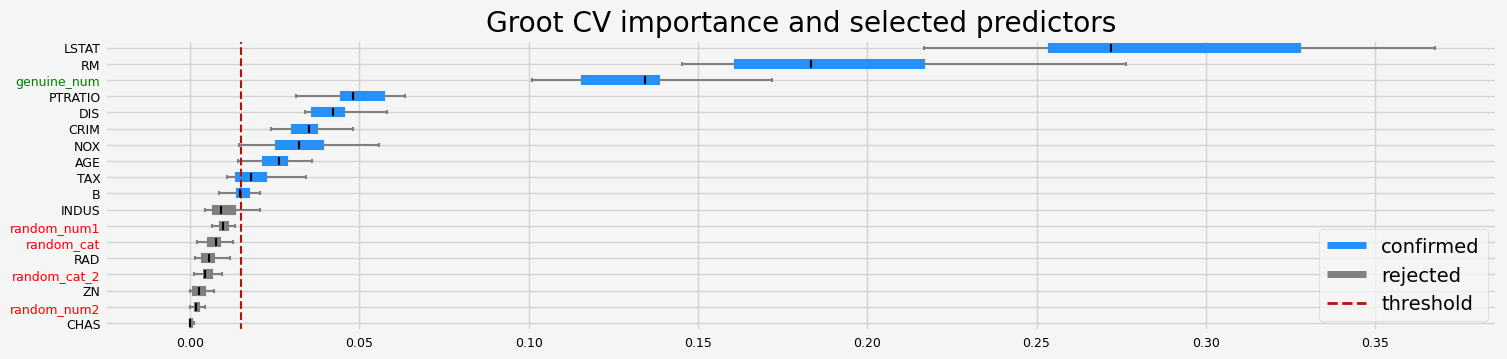

In [26]:
# Testing the changes with rnd cat. and num. predictors added to the set of genuine predictors


def testing_estimators(X, y, sample_weight=None, objective="rmse"):
    feat_selector = arfsgroot.GrootCV(
        objective=objective, cutoff=1, n_folds=5, n_iter=5, fastshap=False
    )
    feat_selector.fit(X, y, sample_weight)
    print(feat_selector.get_feature_names_out())
    fig = feat_selector.plot_importance(n_feat_per_inch=5)

    # highlight synthetic random variable
    fig = highlight_tick(figure=fig, str_match="random")
    fig = highlight_tick(figure=fig, str_match="genuine", color="green")
    plt.show()
    gc.enable()
    del feat_selector
    gc.collect()


if __name__ == "__main__":
    # regression
    boston = load_data(name="Boston")
    X, y = boston.data, boston.target
    cat_f = boston.categorical
    testing_estimators(X=X, y=y, objective="rmse")

Cross Validation:   0%|          | 0/25 [00:00<?, ?it/s]

Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[310]	training's l2: 0.147514	valid_1's l2: 10.9022
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[168]	training's l2: 0.346833	valid_1's l2: 11.4562
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[69]	training's l2: 1.59845	valid_1's l2: 8.31522
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[75]	training's l2: 1.42606	valid_1's l2: 7.71274
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[116]	training's l2: 1.04393	valid_1's l2: 12.044
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[193]	training's l2: 0.251954	valid_1's l2: 11.0387
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[100]	training's l2: 1

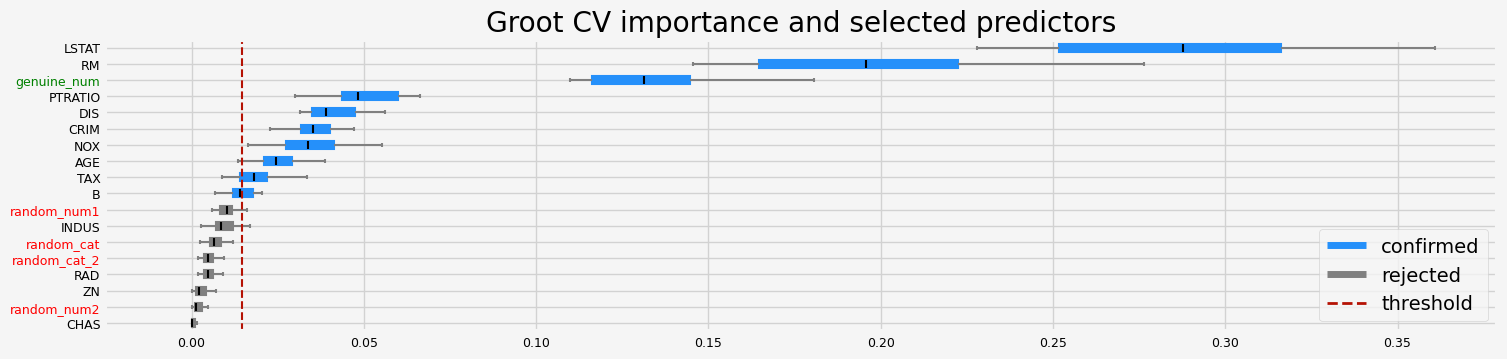

In [28]:
# Testing the changes with rnd cat. and num. predictors added to the set of genuine predictors
def testing_estimators(X, y, sample_weight=None, objective="rmse"):
    feat_selector = arfsgroot.GrootCV(
        objective=objective, cutoff=1, n_folds=5, n_iter=5, fastshap=False
    )
    feat_selector.fit(X, y, sample_weight)
    print(feat_selector.get_feature_names_out())
    fig = feat_selector.plot_importance(n_feat_per_inch=5)

    # highlight synthetic random variable
    fig = highlight_tick(figure=fig, str_match="random")
    fig = highlight_tick(figure=fig, str_match="genuine", color="green")
    plt.show()
    gc.enable()
    del feat_selector
    gc.collect()


if __name__ == "__main__":
    # regression
    boston = load_data(name="Boston")
    X, y = boston.data, boston.target
    cat_f = boston.categorical
    testing_estimators(X=X, y=y, objective="rmse")

### Testing BoostAGroota

==================== BoostAGroota - testing:     RandomForestRegressor for var.imp: shap            ====================


BoostaGRoota round:   0%|          | 0/10 [00:00<?, ?it/s]

['CRIM' 'NOX' 'RM' 'AGE' 'DIS' 'TAX' 'PTRATIO' 'B' 'LSTAT' 'random_num1'
 'genuine_num']


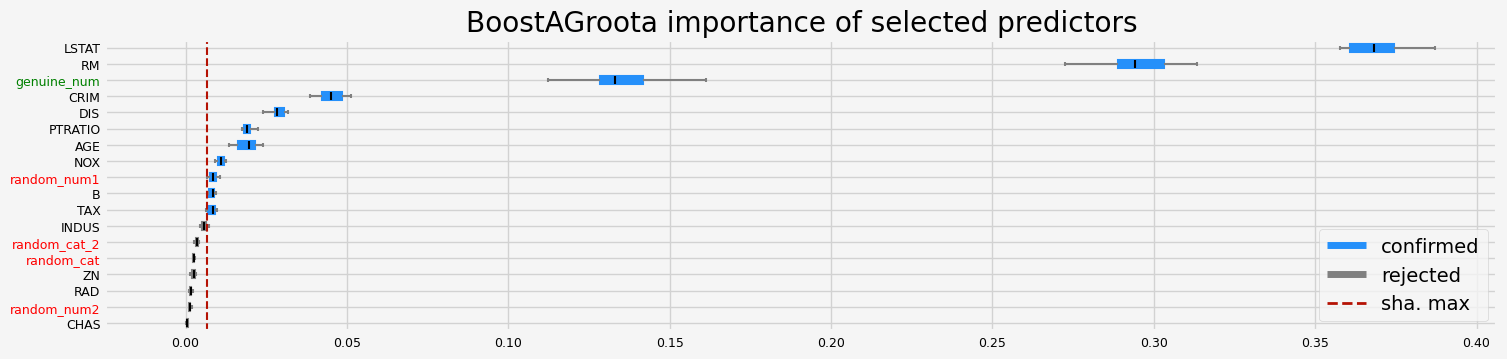

==================== BoostAGroota - testing:     RandomForestRegressor for var.imp: pimp            ====================


BoostaGRoota round:   0%|          | 0/10 [00:00<?, ?it/s]

['CRIM' 'NOX' 'RM' 'AGE' 'DIS' 'TAX' 'PTRATIO' 'LSTAT' 'genuine_num']


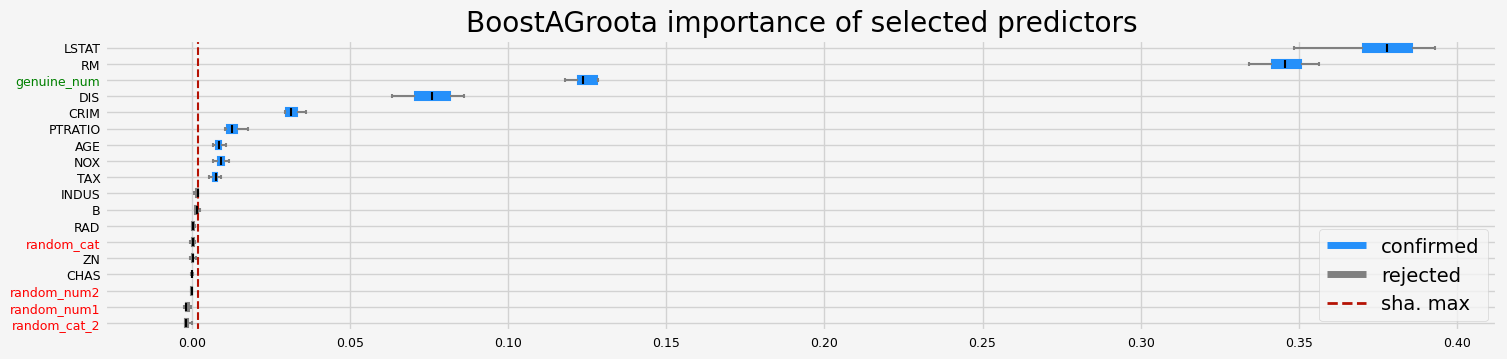

==================== BoostAGroota - testing:     RandomForestRegressor for var.imp: native          ====================


BoostaGRoota round:   0%|          | 0/10 [00:00<?, ?it/s]

['CRIM' 'NOX' 'RM' 'AGE' 'DIS' 'TAX' 'PTRATIO' 'B' 'LSTAT' 'genuine_num']


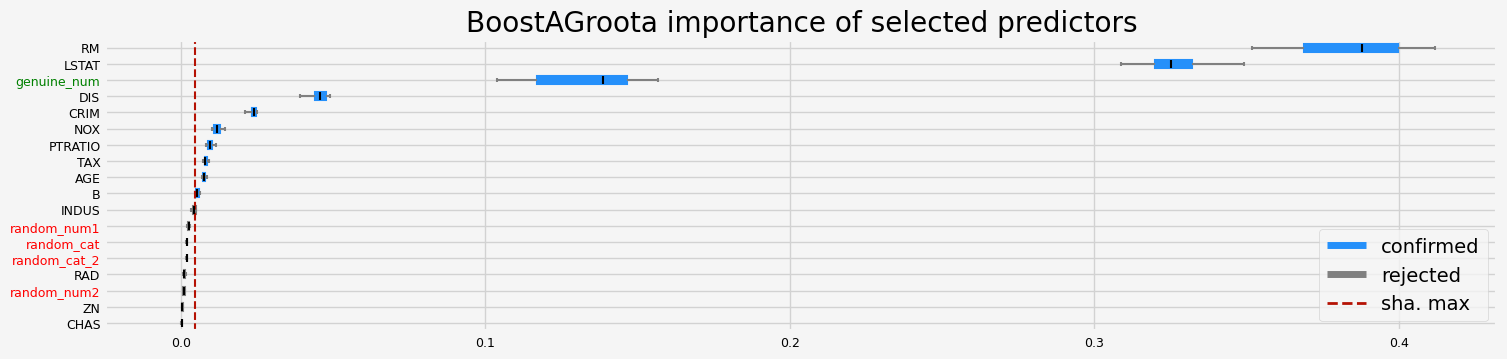

==================== BoostAGroota - testing:         CatBoostRegressor for var.imp: shap            ====================


BoostaGRoota round:   0%|          | 0/10 [00:00<?, ?it/s]

['CRIM' 'INDUS' 'NOX' 'RM' 'AGE' 'DIS' 'TAX' 'PTRATIO' 'B' 'LSTAT'
 'genuine_num']


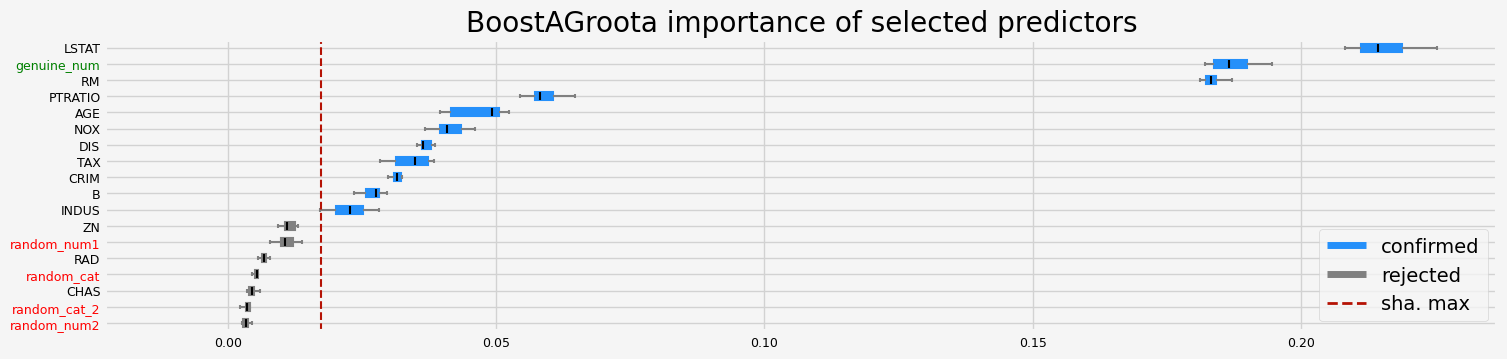

==================== BoostAGroota - testing:         CatBoostRegressor for var.imp: pimp            ====================


BoostaGRoota round:   0%|          | 0/10 [00:00<?, ?it/s]

['CRIM' 'INDUS' 'NOX' 'RM' 'AGE' 'DIS' 'TAX' 'PTRATIO' 'B' 'LSTAT'
 'genuine_num']


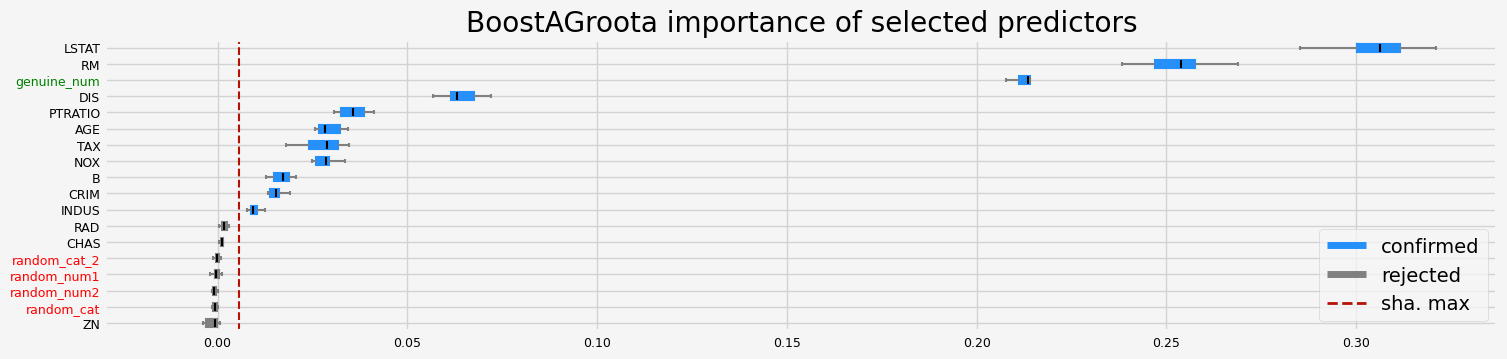

==================== BoostAGroota - testing:         CatBoostRegressor for var.imp: native          ====================


BoostaGRoota round:   0%|          | 0/10 [00:00<?, ?it/s]

['CRIM' 'NOX' 'RM' 'AGE' 'DIS' 'TAX' 'PTRATIO' 'B' 'LSTAT' 'genuine_num']


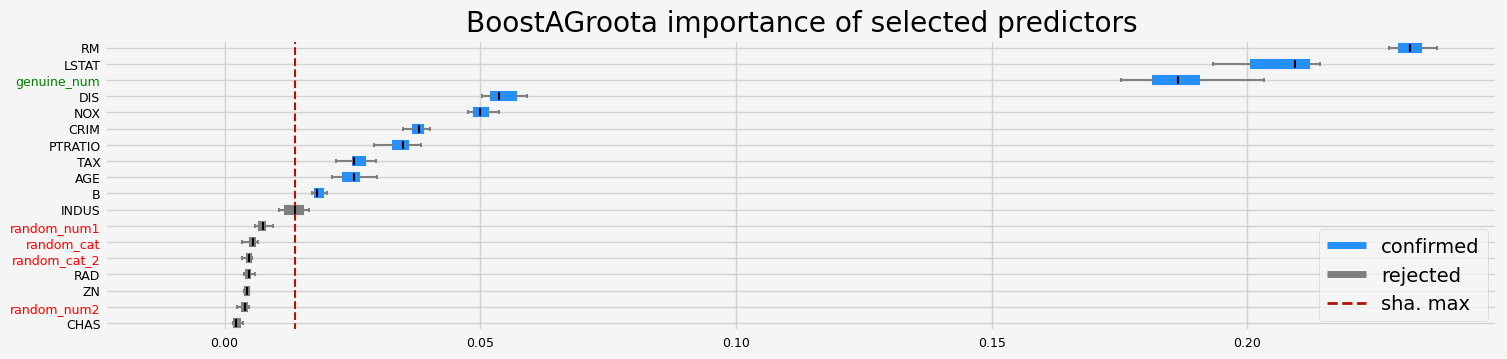

==================== BoostAGroota - testing:             LGBMRegressor for var.imp: shap            ====================


BoostaGRoota round:   0%|          | 0/10 [00:00<?, ?it/s]

['CRIM' 'NOX' 'RM' 'AGE' 'DIS' 'PTRATIO' 'LSTAT' 'genuine_num']


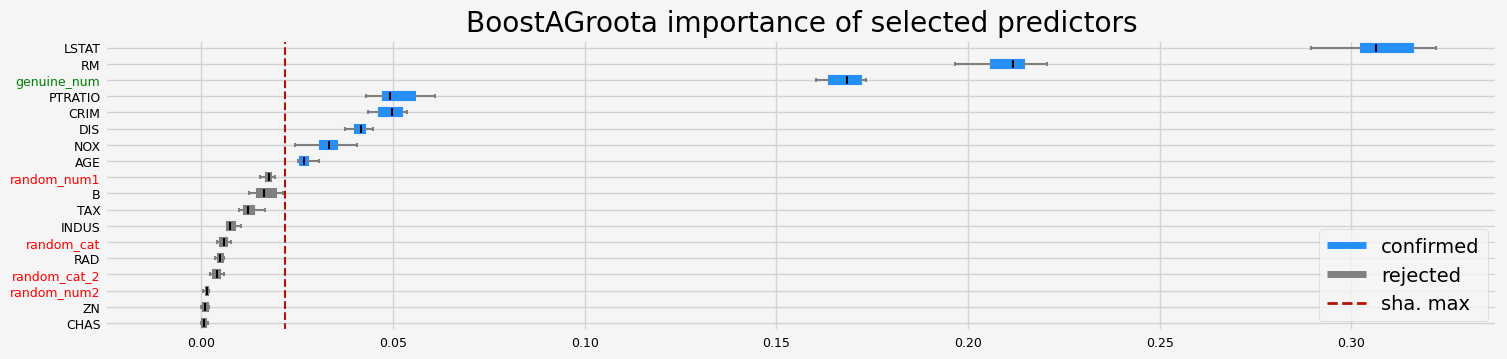

==================== BoostAGroota - testing:             LGBMRegressor for var.imp: pimp            ====================


BoostaGRoota round:   0%|          | 0/10 [00:00<?, ?it/s]

['CRIM' 'NOX' 'RM' 'AGE' 'DIS' 'TAX' 'PTRATIO' 'LSTAT' 'genuine_num']


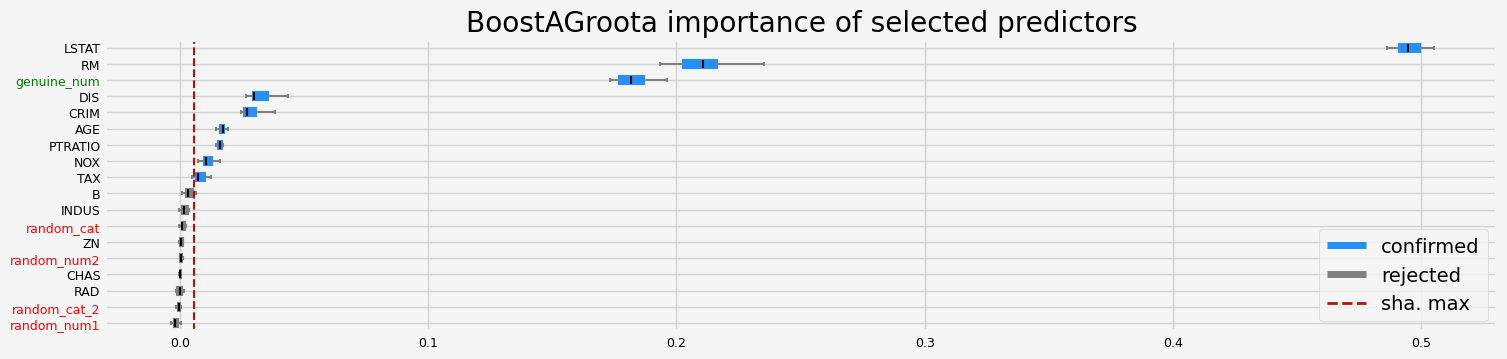

==================== BoostAGroota - testing:             LGBMRegressor for var.imp: native          ====================


BoostaGRoota round:   0%|          | 0/10 [00:00<?, ?it/s]

['CRIM' 'NOX' 'RM' 'AGE' 'DIS' 'TAX' 'PTRATIO' 'B' 'LSTAT' 'genuine_num']


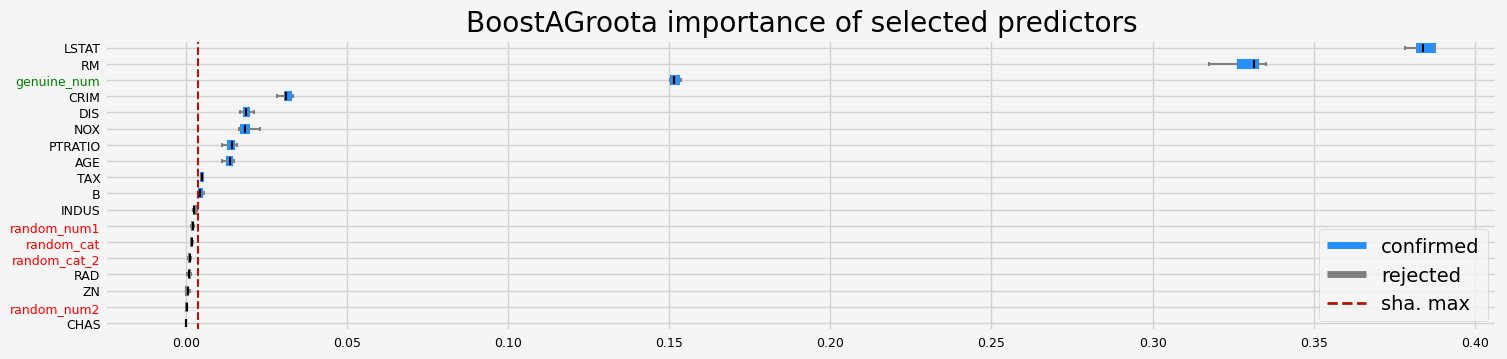

==================== BoostAGroota - testing:             LGBMRegressor for var.imp: shap            ====================


BoostaGRoota round:   0%|          | 0/10 [00:00<?, ?it/s]

['CRIM' 'INDUS' 'RM' 'AGE' 'DIS' 'LSTAT' 'genuine_num']


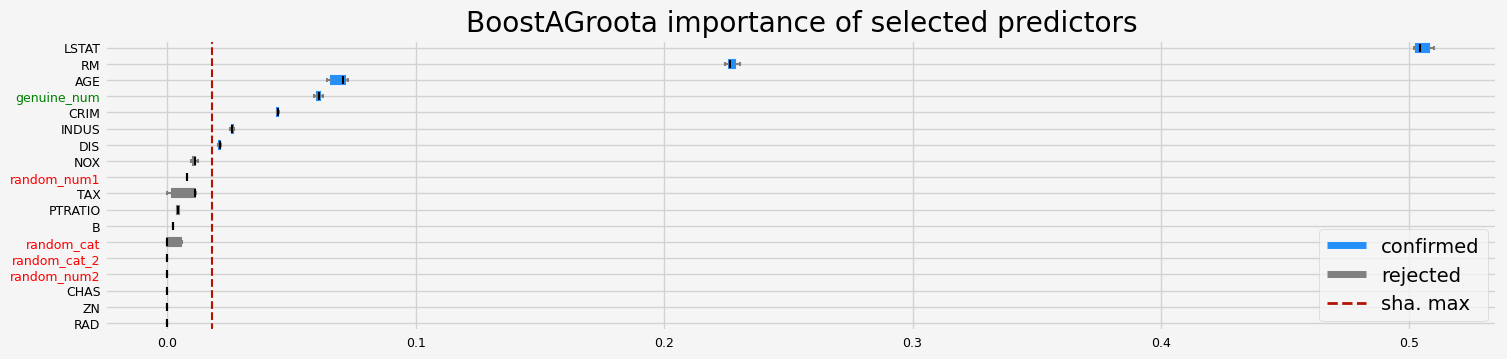

==================== BoostAGroota - testing:             LGBMRegressor for var.imp: pimp            ====================


BoostaGRoota round:   0%|          | 0/10 [00:00<?, ?it/s]

['CRIM' 'NOX' 'RM' 'DIS' 'LSTAT' 'genuine_num']


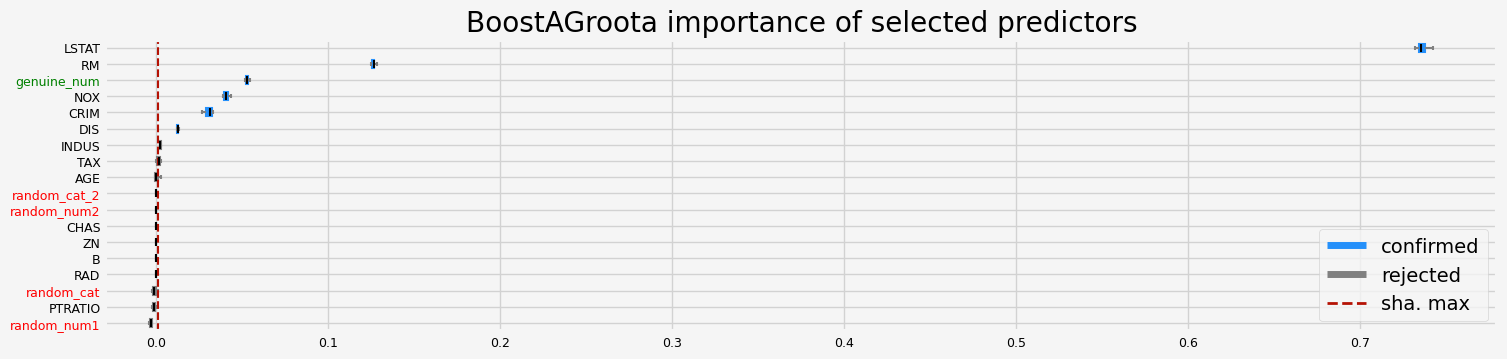

==================== BoostAGroota - testing:             LGBMRegressor for var.imp: native          ====================


BoostaGRoota round:   0%|          | 0/10 [00:00<?, ?it/s]

['CRIM' 'NOX' 'RM' 'AGE' 'DIS' 'RAD' 'TAX' 'PTRATIO' 'LSTAT' 'genuine_num']


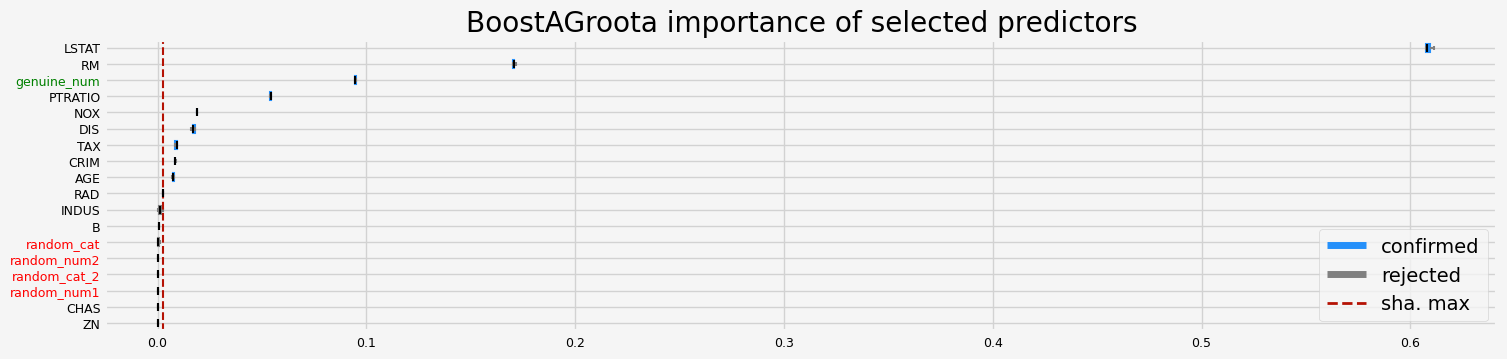

==================== BoostAGroota - testing:              XGBRegressor for var.imp: shap            ====================


BoostaGRoota round:   0%|          | 0/10 [00:00<?, ?it/s]

['CRIM' 'RM' 'AGE' 'DIS' 'PTRATIO' 'B' 'LSTAT' 'genuine_num']


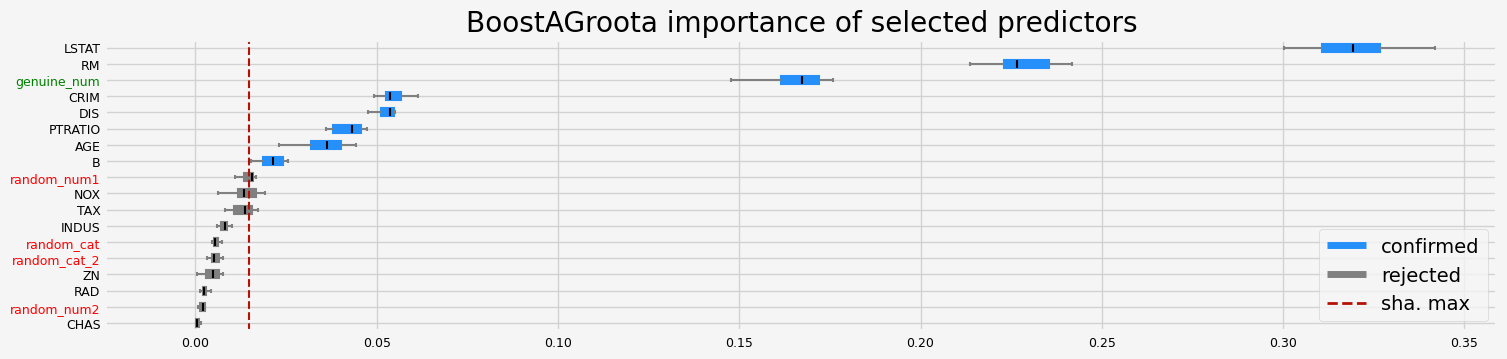

==================== BoostAGroota - testing:              XGBRegressor for var.imp: pimp            ====================


BoostaGRoota round:   0%|          | 0/10 [00:00<?, ?it/s]

['CRIM' 'NOX' 'RM' 'AGE' 'DIS' 'PTRATIO' 'LSTAT' 'genuine_num']


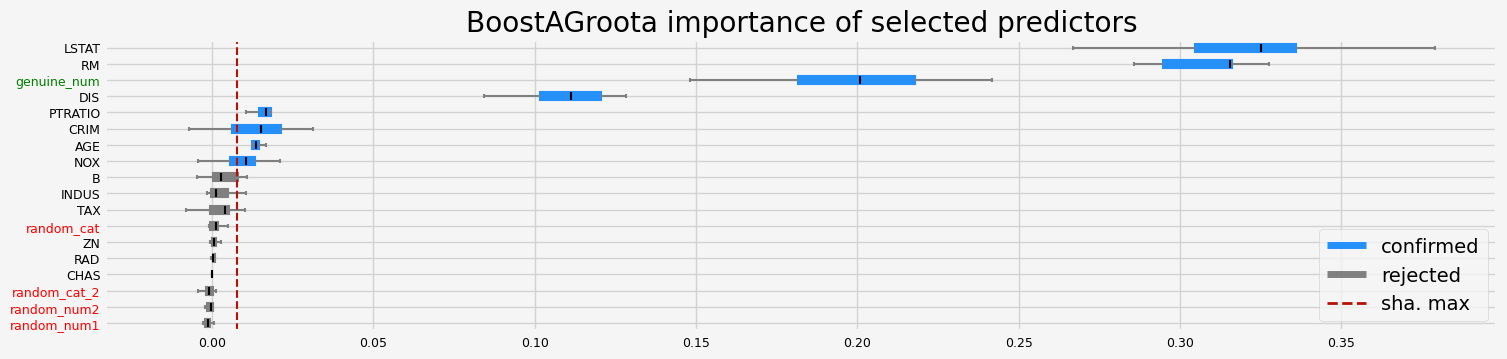

==================== BoostAGroota - testing:              XGBRegressor for var.imp: native          ====================


BoostaGRoota round:   0%|          | 0/10 [00:00<?, ?it/s]

['NOX' 'RM' 'DIS' 'TAX' 'PTRATIO' 'LSTAT' 'genuine_num']


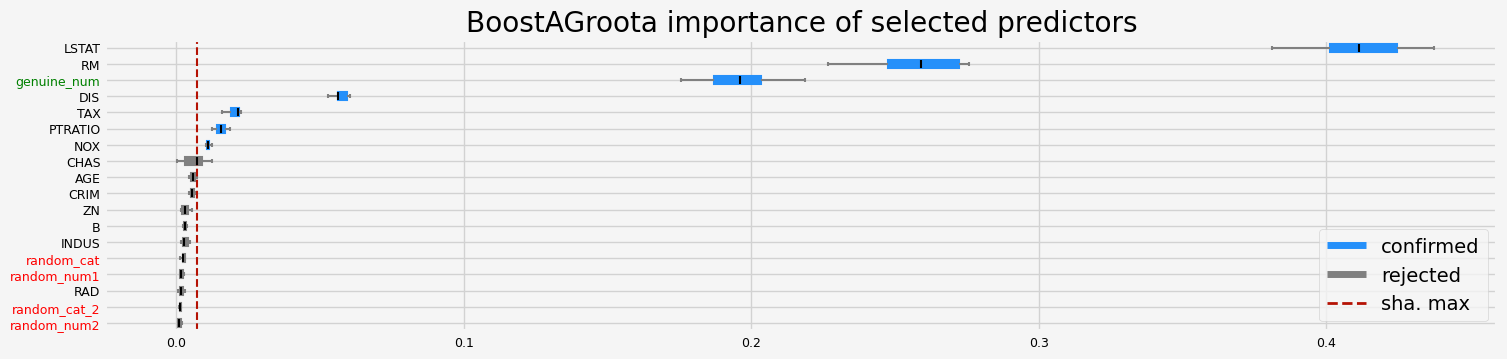

In [29]:
models = [
    RandomForestRegressor(n_jobs=4, oob_score=True),
    CatBoostRegressor(random_state=42, verbose=0),
    LGBMRegressor(random_state=42, verbose=-1),
    LightForestRegressor(n_feat=X.shape[1]),
    XGBRegressor(random_state=42, verbosity=0),
]

feat_selector = arfsgroot.BoostAGroota(
    estimator=model, cutoff=1, iters=10, max_rounds=10, delta=0.1
)

if __name__ == "__main__":
    # regression
    boston = load_data(name="Boston")
    X, y = boston.data, boston.target
    cat_f = boston.categorical
    # running the ARFS methods using different models
    compare_varimp(feat_selector, models, X, y, sample_weight=None)